In [1]:
#This code is for the Fabry-Perot hBN project 


import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
%matplotlib inline
import nplab.datafile as df
import scipy.signal as sig
import scipy.constants as const
import peakutils
import numpy as np
import datetime
from peakutils.plot import plot as pplot
from parula import cm_data
from matplotlib.colors import LinearSegmentedColormap 
from matplotlib.collections import LineCollection
import os
import Alexsdatafuncs
import matplotlib.cm as cm
import time
import scipy.integrate as integrate
import scipy.special as special


In [2]:
parula_map = LinearSegmentedColormap.from_list('parula', cm_data)
copper_map = LinearSegmentedColormap.from_list('copper', cm_data)

Alex_data = Alexsdatafuncs.data_manipulators()
Alex_plot = Alexsdatafuncs.plotting_funcs()

In [3]:
#    
def big_for(filelist, start_time, finish_time, max_peaks = 7, wavelength_start = 405, wavelength_end = 1000, 
            peakfind_start = 401):
    
    wavelengthvals = filelist[filelist.keys()[0]].attrs['wavelengths']
    data_start = (np.abs(wavelengthvals - wavelength_start)).argmin()
    data_end = (np.abs(wavelengthvals - wavelength_end)).argmin()
    peak_data_start = (np.abs(wavelengthvals - peakfind_start)).argmin()
    data_range = data_end - data_start
    peak_index_store = []
    wavelength_store = []
    name_store = []
    intensity_store_norm = []
    intensity_store = []
    peak_wavelengths_store = []
    peak_intensities_store = []
    min_indexes = []
    min_index_store = []
    min_wavelengths_store = []
    min_intensities_store = []
    
    #Search for reference spectrum   
    try:
        for i in range(0, len(filelist)):
            try:
                ref = filelist[filelist.keys()[i]].attrs['reference']
                print "Reference spectrum taken from spectrum: " 
                print filelist.keys()[i]
                break
            except KeyError:
                ref = filelist[filelist.keys()[0]]
                pass
    except KeyError:
        print """Coudn't find a stored reference attribute, \n
        find the file containing a reference and paste this into the code"""
        ref = filelist[filelist.keys()[0]]
    
    back = filelist[filelist.keys()[0]].attrs['background']
    x = wavelengthvals

    slash_loc = Alex_data.slashfinder(fname)

    spectrum_indexes = []
    num_peaks_store = []
    intensity_initial_peak_store = []
    initial_peak_wl_store = []
    second_peak_wl_store = []

    peak_width_guess = 50
    exp_number_of_peaks = 2

    no_spectra=-1

    for data_set in filelist.values():

        current_timestamp =  datetime.datetime.strptime(
                data_set.attrs['creation_timestamp'][:19], "%Y-%m-%dT%H:%M:%S")

        no_spectra += 1

        if current_timestamp >= start_time and current_timestamp <= finish_time:

            print "Current spectrum: " + data_set.name[25:]

            spectrum_indexes = np.append(spectrum_indexes, [no_spectra])

            y_raw = np.array(data_set.value)
            y = (y_raw-back)/(ref-back)

            y_red = y[data_start:data_end]
            x_red = x[data_start:data_end]

            #Use Savitsky-Golay noise filter to remove noise if chosen


            y_filtered = sig.savgol_filter(y_red,23,3)
            y_filtered_corr = y_filtered - min(y_filtered)
            y_norm = (y_filtered_corr/max(y_filtered_corr))
            y_red = y_filtered
    #         else:
    #             y_red = y[data_start:data_end] - min(y[data_start:data_end])
    #             y_norm = (y_red/max(y_red))
    #             pass

            #Set peakfinder to only search above set wavelength value with 
            #peak_data_start

            #Automatically search for the correct threshold leading the code to 
            #find the defined number of peaks
            thresh_guess = 0.5
            find_peaks = False
            while find_peaks == False and exp_number_of_peaks != 0:
                peak_indexes = peakutils.indexes(y_norm[peak_data_start:data_end], 
                                                 thres = thresh_guess, 
                                                 min_dist = peak_width_guess*2)
                min_indexes = peakutils.indexes(-1*y_norm[peak_data_start:data_end], 
                                                 thres = thresh_guess, 
                                                 min_dist = peak_width_guess*2)
                if len(peak_indexes) >= exp_number_of_peaks:
                    find_peaks = True
                elif thresh_guess <=0.01:
                    while find_peaks == False:
                        peak_indexes = peakutils.indexes(y_norm[peak_data_start:data_end], 
                                                         thres = thresh_guess, 
                                                         min_dist = peak_width_guess*2)
                        min_indexes = peakutils.indexes(-1*y_norm[peak_data_start:data_end], 
                                                 thres = thresh_guess, 
                                                 min_dist = peak_width_guess*2)
                        if len(peak_indexes) >= exp_number_of_peaks:
                            find_peaks = True
                        elif thresh_guess > 1:
                            print "Didn't find threshold for spectrum" + str(no_spectra)
                            print "Need to change expected number or peaks"
                            thresh_guess = 0.5
                            break
                        else:
                            thresh_guess += 0.01
                    break
                else:
                    thresh_guess -= 0.01

            peak_indexes = peak_indexes + peak_data_start
            min_indexes = min_indexes + peak_data_start
            peak_indexes_orig = peak_indexes
            num_peaks = len(peak_indexes_orig)
            
            #Crop and add points to minima peaks
            if len(min_indexes) > max_peaks:
                while len(min_indexes) > max_peaks:
                    min_indexes = np.delete(min_indexes,[max_peaks])
            elif len(min_indexes) < max_peaks:
                while len(min_indexes) < max_peaks:
                    min_indexes = np.append(min_indexes,[0])
            else:
                pass
            
            #Crop and add 0 to peaks
            if len(peak_indexes) > max_peaks:
                while len(peak_indexes) > max_peaks:
                    peak_indexes = np.delete(peak_indexes,[max_peaks])
            elif len(peak_indexes) < max_peaks:
                while len(peak_indexes) < max_peaks:
                    peak_indexes = np.append(peak_indexes,[0])
            else:
                pass

            peak_wavelengths = []
            min_wavelengths = []
            peak_intensities = []
            min_intensities = []
            for i in range(0,max_peaks):
                if peak_indexes[i] != 0:
                    peak_wavelengths = np.append(peak_wavelengths, 
                                                 [x_red[peak_indexes[i]]])
                else:
                    peak_wavelengths = np.append(peak_wavelengths, [0])
                    
                if peak_indexes[i] != 0:
                    peak_intensities = np.append(peak_intensities, 
                                                 [y_norm[peak_indexes[i]]])
                else:
                    peak_intensities = np.append(peak_intensities, [0])
                    
                if min_indexes[i] != 0:
                    min_wavelengths = np.append(min_wavelengths, 
                                                 [x_red[min_indexes[i]]])
                else:
                    min_wavelengths = np.append(min_wavelengths, [0])
                    
                if min_indexes[i] != 0:
                    min_intensities = np.append(min_intensities, 
                                                 [y_norm[min_indexes[i]]])
                else:
                    min_intensities = np.append(min_intensities, [0])

    
                

            #Gaussian fitting    

    #         try:
    #             multi_gauss_fit_a = Alex_data.gaussian_fit_2(y_norm, x_red, 
    #                                                          peak_indexes_orig, 
    #                                                          peak_intensities)
    #         except UnboundLocalError:
    #             print "Gauss fit didnt work for spectrum" + str(no_spectra) 
    #             pass
    #         else:
    #             pass

            wavelength_store.append(x_red)
            name_store.append(data_set.name[25:])
            intensity_store.append(y_red)
            intensity_store_norm.append(y_norm)
            peak_index_store.append(peak_indexes)
            min_index_store.append(min_indexes)
            peak_wavelengths_store.append(peak_wavelengths)
            peak_intensities_store.append(peak_intensities)
            min_wavelengths_store.append(min_wavelengths)
            min_intensities_store.append(min_intensities)
            num_peaks_store = np.append(num_peaks_store, num_peaks)
            intensity_initial_peak_store = np.append(intensity_initial_peak_store, 
                                                     peak_intensities[0])
            initial_peak_wl_store = np.append(initial_peak_wl_store,peak_wavelengths[0])
            second_peak_wl_store = np.append(second_peak_wl_store, peak_wavelengths[1])

        else:
            pass
        
    wavelength_store = np.array(wavelength_store)        
    intensity_store = np.array(intensity_store)
    name_store = np.array(name_store)
    intensity_store_norm = np.array(intensity_store_norm)
    peak_index_store = np.array(peak_index_store)
    min_index_store = np.array(min_index_store)
    min_wavelengths_store = np.array(min_wavelengths_store)
    min_intensities_store = np.array(min_intensities_store)
    peak_wavelengths_store = np.array(peak_wavelengths_store)
    peak_intensities_store = np.array(peak_intensities_store)
    num_peaks_store = np.array(num_peaks_store)
    intensity_initial_peak_store = np.array(intensity_initial_peak_store)
    initial_peak_wl_store = np.array(initial_peak_wl_store)
    second_peak_wl_store = np.array(second_peak_wl_store)
    
    return wavelength_store, intensity_store, name_store, intensity_store_norm, peak_index_store, peak_wavelengths_store,peak_intensities_store, num_peaks_store, intensity_initial_peak_store,initial_peak_wl_store, second_peak_wl_store, min_index_store, min_wavelengths_store, min_intensities_store  


In [4]:
#Calculate useful values
def val_calc(num_peaks_store, second_peak_wl_store, initial_peak_wl_store, wavelength_store, 
             intensity_initial_peak_store, intensity_store_norm, intensity_store, av_init_peak_pos = 660):
    av_num_peaks = np.mean(num_peaks_store)
    av_second_peak_pos = np.mean(second_peak_wl_store)
    av_init_peak_pos_stddev = np.std(initial_peak_wl_store)
    av_second_peak_pos_stdev = np.std(second_peak_wl_store)
    av_init_peak_pos = 660

    init_peak = []
    second_peak = []
    for i in range(0, len(initial_peak_wl_store)): 
        if initial_peak_wl_store[i] < (av_init_peak_pos + av_init_peak_pos_stddev):
            init_peak = np.append(init_peak, initial_peak_wl_store[i])
        else:
            pass
    av_init_peak = np.mean(init_peak)
    for i in range(0, len(second_peak_wl_store)): 
        if initial_peak_wl_store[i] < (av_second_peak_pos + av_second_peak_pos_stdev):
            second_peak = np.append(second_peak, second_peak_wl_store[i])
        else:
            pass
    # if answers[6] == True:    
    #     ax1.plot([av_init_peak]*len(np.linspace(64,70)), np.linspace(64,70),'r--')
    #     ax1.plot([av_second_peak_pos]*len(np.linspace(64,70)), np.linspace(64,70),'r--')
    # else:
    #     pass

    av_init_peak_intensities = np.mean(intensity_initial_peak_store)
    average_all_intensities_norm = np.mean(intensity_store_norm, axis=0)
    average_all_intensities = np.mean(intensity_store, axis=0)
    av_stddev_norm = (np.std((intensity_store_norm), axis=0, dtype = np.float64))/np.sqrt(len(wavelength_store))
    av_stddev = np.std((intensity_store), axis=0, dtype = np.float64)/np.sqrt(len(wavelength_store))


    min_peak_pos_av = wavelength_store[0][np.argmin(average_all_intensities_norm)]

    return av_init_peak_intensities, average_all_intensities_norm, average_all_intensities, av_stddev_norm, av_stddev, min_peak_pos_av

In [19]:
cd ('C:/Users/alexc/OneDrive-University Of Cambridge/Documents/PhD Project/Projects')

[Error 123] The filename, directory name, or volume label syntax is incorrect: u"('C:/Users/alexc/OneDrive-University Of Cambridge/Documents/PhD Project/Projects')"
C:\Users\alexc\Documents\PhD Project\Python data analysis scripts\Dark field scattering


In [ ]:
data_f.close()

In [ ]:
data_f.open_gui()

In [5]:
data_f = df.current()
fname = data_f.filename

No current data file, attempting to create...
C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN publication/2017_12_11 041217 hBN in Au_DF/2017-12-05_60nm NP.h5
opening file:  C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN publication/2017_12_11 041217 hBN in Au_DF/2017-12-05_60nm NP.h5


In [6]:
filelist_DF = data_f['OceanOpticsSpectrometer']
camlist_DF = data_f['LumeneraCamera']

In [7]:
Wl_ref = filelist_DF[filelist_DF.keys()[0]].attrs["reference"]
np.savetxt("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN publication/2017_12_11 041217 hBN in Au_DF/Wl_ref.txt", Wl_ref, delimiter = "\t")

C:\Users\alexc\Anaconda2\lib\site-packages\matplotlib\figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


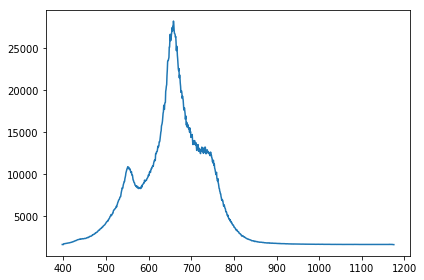

In [11]:
Au_R_raw_BF = data_f['OceanOpticsSpectrometer'][data_f['OceanOpticsSpectrometer'].keys()[0]]
wl_raw = data_f['OceanOpticsSpectrometer'][data_f['OceanOpticsSpectrometer'].keys()[0]].attrs["wavelengths"]
#WhiteL_raw_DF = filelist_DF[filelist_DF.keys()[0]].attrs["background"]
#np.savetxt("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN/2017_12_05 041217 hBN in Au_100x BF/Au_R_raw", Au_R_raw_BF, delimiter = "\t")



plt.plot(wl_raw, Au_R_raw_BF)

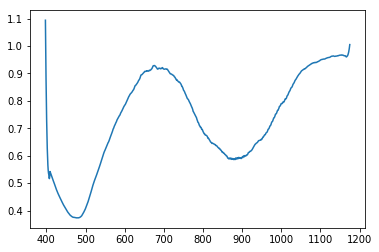

In [428]:
wl_ref_0 = np.array(np.genfromtxt("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN/2017_12_11 041217 hBN in Au_DF/Wl_ref.txt", delimiter = "/t"))
Au_R_raw_BF_0 = np.array(np.genfromtxt("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN/2017_12_05 041217 hBN in Au_100x BF/Au_R_raw.txt", delimiter = "/t"))
wl_raw = data_f['OceanOpticsSpectrometer'][data_f['OceanOpticsSpectrometer'].keys()[0]].attrs["wavelengths"]
#plt.plot(wl_raw, wl_ref_0)
#plt.plot(wl_raw, Au_R_raw_BF_0)
Au_R = Au_R_raw_BF_0/wl_ref_0
Au_R_smooth = sig.savgol_filter(Au_R,23,3)
plt.plot(wl_raw, Au_R_smooth)

In [7]:
#Select range of times data taken for terrace 2 DF
start_time_o = datetime.datetime.strptime('2017-12-05T15:27:59.733000', 
                                        "%Y-%m-%dT%H:%M:%S.%f")
finish_time_o = datetime.datetime.strptime('2017-12-05T15:35:36.756000', 
                                        "%Y-%m-%dT%H:%M:%S.%f")

In [8]:
#Select range of times data taken for terrace 1 DF
start_time_g = datetime.datetime.strptime('2017-12-05T15:51:36.805000', 
                                        "%Y-%m-%dT%H:%M:%S.%f")
finish_time_g = datetime.datetime.strptime('2017-12-05T16:02:02.837000', 
                                        "%Y-%m-%dT%H:%M:%S.%f") 

In [8]:
#Select range of times data taken terrace 1 BF
start_time_bg = datetime.datetime.strptime('2017-12-05T11:15:14.197000', 
                                        "%Y-%m-%dT%H:%M:%S.%f")
finish_time_bg = datetime.datetime.strptime('2017-12-05T11:16:31.200000', 
                                        "%Y-%m-%dT%H:%M:%S.%f") 

In [9]:
#Select range of times data taken for terrace 2 BF
start_time_bo = datetime.datetime.strptime('2017-12-05T11:16:31.200000', 
                                        "%Y-%m-%dT%H:%M:%S.%f")
finish_time_bo = datetime.datetime.strptime('2017-12-05T11:17:11.802000', 
                                        "%Y-%m-%dT%H:%M:%S.%f") 

In [9]:
start_time_bp = datetime.datetime.strptime('2017-12-05T11:17:11.802000', 
                                        "%Y-%m-%dT%H:%M:%S.%f")
finish_time_bp = datetime.datetime.strptime('2017-12-05T11:18:43.007000', 
                                        "%Y-%m-%dT%H:%M:%S.%f") 

In [38]:
start_time_t2edge = datetime.datetime.strptime('2017-12-05T15:48:26.794000', 
                                        "%Y-%m-%dT%H:%M:%S.%f")
finish_time_t2edge = datetime.datetime.strptime('2017-12-05T15:49:05.797000', 
                                        "%Y-%m-%dT%H:%M:%S.%f") 

In [10]:
start_time_cedge = datetime.datetime.strptime('2017-12-05T15:49:29.799000', 
                                        "%Y-%m-%dT%H:%M:%S.%f")
finish_time_cedge = datetime.datetime.strptime('2017-12-05T15:50:35.801000', 
                                        "%Y-%m-%dT%H:%M:%S.%f")

In [11]:
start_time_t1edge = datetime.datetime.strptime('2017-12-05T16:05:44.848000', 
                                        "%Y-%m-%dT%H:%M:%S.%f")
finish_time_t1edge = datetime.datetime.strptime('2017-12-05T16:07:19.853000', 
                                        "%Y-%m-%dT%H:%M:%S.%f")

In [19]:
start_time_fano2 = datetime.datetime.strptime('2017-12-05T15:50:35.801000', 
                                        "%Y-%m-%dT%H:%M:%S.%f")
finish_time_fano2 = datetime.datetime.strptime('2017-12-05T15:51:36.805000', 
                                        "%Y-%m-%dT%H:%M:%S.%f")

In [12]:
wavelength_store_g, intensity_store_g, name_store_g, intensity_store_norm_g, \
peak_index_store_g, peak_wavelengths_store_g, peak_intensities_store_g, num_peaks_store_g,\
intensity_initial_peak_store_g, initial_peak_wl_store_g,\
second_peak_wl_store_g, min_indexes_store_g, \
min_wavelengths_store_g, min_intensities_store_g = big_for(filelist = filelist_DF, start_time = start_time_g, finish_time = finish_time_g, max_peaks = 7, 
          wavelength_start = 405,wavelength_end = 1000, peakfind_start = 401)


Reference spectrum taken from spectrum: 
Flake 1_centre edge_0
Current spectrum: Flake 1_terrace 2_NP10_0


C:\Users\alexc\Anaconda2\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in divide


Current spectrum: Flake 1_terrace 2_NP11_0
Current spectrum: Flake 1_terrace 2_NP12_0
Current spectrum: Flake 1_terrace 2_NP13_0
Current spectrum: Flake 1_terrace 2_NP14_0
Current spectrum: Flake 1_terrace 2_NP15_0
Current spectrum: Flake 1_terrace 2_NP16_0
Current spectrum: Flake 1_terrace 2_NP17_0
Current spectrum: Flake 1_terrace 2_NP18_0
Current spectrum: Flake 1_terrace 2_NP19_0
Current spectrum: Flake 1_terrace 2_NP20_0
Current spectrum: Flake 1_terrace 2_NP21_0
Current spectrum: Flake 1_terrace 2_NP22_0
Current spectrum: Flake 1_terrace 2_NP3_0
Current spectrum: Flake 1_terrace 2_NP4_0


C:\Users\alexc\Anaconda2\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in divide


Current spectrum: Flake 1_terrace 2_NP5_0
Current spectrum: Flake 1_terrace 2_NP6_0
Current spectrum: Flake 1_terrace 2_NP7_0
Current spectrum: Flake 1_terrace 2_NP8_0
Current spectrum: Flake 1_terrace 2_NP9_0
Current spectrum: Flake 1_terrance 2_NP1_0
Current spectrum: Flake 1_terrance 2_NP2_0


In [13]:
wavelength_store_o, intensity_store_o, name_store_o, intensity_store_norm_o, \
peak_index_store_o, peak_wavelengths_store_o, peak_intensities_store_o, num_peaks_store_o,\
intensity_initial_peak_store_o, initial_peak_wl_store_o,\
second_peak_wl_store_o, min_indexes_store_o, \
min_wavelengths_store_o, min_intensities_store_o = big_for(filelist = filelist_DF, start_time = start_time_o, finish_time = finish_time_o, max_peaks = 7, 
          wavelength_start = 405,wavelength_end = 1000, peakfind_start = 401)


Reference spectrum taken from spectrum: 
Flake 1_centre edge_0
Current spectrum: Flake 1_terrace 1_NP10_0


C:\Users\alexc\Anaconda2\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in divide


Current spectrum: Flake 1_terrace 1_NP11_0


C:\Users\alexc\Anaconda2\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in divide


Current spectrum: Flake 1_terrace 1_NP12_0
Current spectrum: Flake 1_terrace 1_NP13_0
Current spectrum: Flake 1_terrace 1_NP14_0
Current spectrum: Flake 1_terrace 1_NP15_0
Current spectrum: Flake 1_terrace 1_NP16_0
Current spectrum: Flake 1_terrace 1_NP17_0
Current spectrum: Flake 1_terrace 1_NP2_0
Current spectrum: Flake 1_terrace 1_NP3_0
Current spectrum: Flake 1_terrace 1_NP4_0
Current spectrum: Flake 1_terrace 1_NP5_0
Current spectrum: Flake 1_terrace 1_NP6_0
Current spectrum: Flake 1_terrace 1_NP7_0
Current spectrum: Flake 1_terrace 1_NP8_0
Current spectrum: Flake 1_terrace 1_NP9_0


In [10]:
#Green terrace BF processing
wavelength_store_bg, intensity_store_bg, name_store_bg, intensity_store_norm_bg, \
peak_index_store_bg, peak_wavelengths_store_bg, peak_intensities_store_bg, num_peaks_store_bg,\
intensity_initial_peak_store_bg, initial_peak_wl_store_bg,\
second_peak_wl_store_bg, min_indexes_store_bg, \
min_wavelengths_store_bg, min_intensities_store_bg = big_for(filelist = filelist_BF, start_time = start_time_bg, finish_time = finish_time_bg, max_peaks = 7, 
          wavelength_start = 405,wavelength_end = 1000, peakfind_start = 401)

Current spectrum: Flake 1_terrace 1_green_0


C:\Users\alexc\Anaconda2\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in divide


In [11]:
#Orange terrace BF processing
wavelength_store_bo, intensity_store_bo, name_store_bo, intensity_store_norm_bo, \
peak_index_store_bo, peak_wavelengths_store_bo, peak_intensities_store_bo, num_peaks_store_bo,\
intensity_initial_peak_store_bo, initial_peak_wl_store_bo,\
second_peak_wl_store_bo, min_indexes_store_bo, \
min_wavelengths_store_bo, min_intensities_store_bo = big_for(filelist = filelist_BF, start_time = start_time_bo, finish_time = finish_time_bo, max_peaks = 7, 
          wavelength_start = 405,wavelength_end = 1000, peakfind_start = 401)

Current spectrum: Flake 1_terrace 2_orange_0


C:\Users\alexc\Anaconda2\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in divide


In [12]:
#Pink terrace BF processing
wavelength_store_bp, intensity_store_bp, name_store_bp, intensity_store_norm_bp, \
peak_index_store_bp, peak_wavelengths_store_bp, peak_intensities_store_bp, num_peaks_store_bp,\
intensity_initial_peak_store_bp, initial_peak_wl_store_bp,\
second_peak_wl_store_bp, min_indexes_store_bp, \
min_wavelengths_store_bp, min_intensities_store_bp = big_for(filelist = filelist_BF, start_time = start_time_bp, finish_time = finish_time_bp, max_peaks = 7, 
          wavelength_start = 405,wavelength_end = 1000, peakfind_start = 401)

Current spectrum: Flake 1_terrace 3_pink_0


C:\Users\alexc\Anaconda2\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in divide


In [14]:
#Terrace 1 edge processing
wavelength_store_t1edge, intensity_store_t1edge, name_store_t1edge, intensity_store_norm_t1edge, \
peak_index_store_t1edge, peak_wavelengths_store_t1edge, peak_intensities_store_t1edge, num_peaks_store_t1edge,\
intensity_initial_peak_store_t1edge, initial_peak_wl_store_t1edge,\
second_peak_wl_store_t1edge, min_indexes_store_t1edge, \
min_wavelengths_store_t1edge, min_intensities_store_t1edge = big_for(filelist = filelist_DF, start_time = start_time_t1edge, finish_time = finish_time_t1edge, max_peaks = 7, 
          wavelength_start = 405,wavelength_end = 1000, peakfind_start = 401)

Reference spectrum taken from spectrum: 
Flake 1_centre edge_0
Current spectrum: Flake 1_terrace 2_edge_0


C:\Users\alexc\Anaconda2\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in divide


In [39]:
#Terrace 2 edge processing
wavelength_store_t2edge, intensity_store_t2edge, name_store_t2edge, intensity_store_norm_t2edge, \
peak_index_store_t2edge, peak_wavelengths_store_t2edge, peak_intensities_store_t2edge, num_peaks_store_t2edge,\
intensity_initial_peak_store_t2edge, initial_peak_wl_store_t2edge,\
second_peak_wl_store_t2edge, min_indexes_store_t2edge, \
min_wavelengths_store_t2edge, min_intensities_store_t2edge = big_for(filelist = filelist_DF, start_time = start_time_t2edge, finish_time = finish_time_t2edge, max_peaks = 7, 
          wavelength_start = 405,wavelength_end = 1000, peakfind_start = 401)

Reference spectrum taken from spectrum: 
Flake 1_centre edge_0
Current spectrum: Flake 1_terrace 1_edge 2_0


C:\Users\alexc\Anaconda2\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in divide


In [16]:
#Terrace 2 edge processing
wavelength_store_cedge, intensity_store_cedge, name_store_cedge, intensity_store_norm_cedge, \
peak_index_store_cedge, peak_wavelengths_store_cedge, peak_intensities_store_cedge, num_peaks_store_cedge,\
intensity_initial_peak_store_cedge, initial_peak_wl_store_cedge,\
second_peak_wl_store_cedge, min_indexes_store_cedge, \
min_wavelengths_store_cedge, min_intensities_store_cedge = big_for(filelist = filelist_DF, start_time = start_time_cedge, finish_time = finish_time_cedge, max_peaks = 7, 
          wavelength_start = 405,wavelength_end = 1000, peakfind_start = 401)

Reference spectrum taken from spectrum: 
Flake 1_centre edge_0
Current spectrum: Flake 1_centre edge_0


C:\Users\alexc\Anaconda2\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in divide


In [20]:
#Fano 2 background processing
wavelength_store_fano2, intensity_store_fano2, name_store_fano2, intensity_store_norm_fano2, \
peak_index_store_fano2, peak_wavelengths_store_fano2, peak_intensities_store_fano2, num_peaks_store_fano2,\
intensity_initial_peak_store_fano2, initial_peak_wl_store_fano2,\
second_peak_wl_store_fano2, min_indexes_store_fano2, \
min_wavelengths_store_fano2, min_intensities_store_fano2 = big_for(filelist = filelist_DF, start_time = start_time_fano2, finish_time = finish_time_fano2, max_peaks = 7, 
          wavelength_start = 405,wavelength_end = 1000, peakfind_start = 401)

Reference spectrum taken from spectrum: 
Flake 1_centre edge_0
Current spectrum: Flake 1_terrance 1_centre_0


C:\Users\alexc\Anaconda2\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in divide


In [17]:
#Average and useful values for green terrace NPs
av_init_peak_intensities_g, average_all_intensities_norm_g, \
average_all_intensities_g, av_stddev_norm_g, av_stddev_g, \
min_peak_pos_av_g = val_calc(num_peaks_store = num_peaks_store_g, 
                             second_peak_wl_store = second_peak_wl_store_g, 
                             initial_peak_wl_store = initial_peak_wl_store_g, 
                             intensity_initial_peak_store = intensity_initial_peak_store_g,  
                             wavelength_store = wavelength_store_g, 
                             intensity_store_norm = intensity_store_norm_g,
                             intensity_store = intensity_store_g, av_init_peak_pos = 660)


In [18]:
#Average and useful values for orange terrace NPs
av_init_peak_intensities_o, average_all_intensities_norm_o, \
average_all_intensities_o, av_stddev_norm_o, av_stddev_o, \
min_peak_pos_av_o = val_calc(num_peaks_store = num_peaks_store_o, 
                             second_peak_wl_store = second_peak_wl_store_o, 
                             initial_peak_wl_store = initial_peak_wl_store_o, 
                             intensity_initial_peak_store = intensity_initial_peak_store_o,  
                             wavelength_store = wavelength_store_o, 
                             intensity_store_norm = intensity_store_norm_o,
                             intensity_store = intensity_store_o, av_init_peak_pos = 660)

In [14]:
#Average and useful values for green terrace BF
av_init_peak_intensities_bg, average_all_intensities_norm_bg, \
average_all_intensities_bg, av_stddev_norm_bg, av_stddev_bg, \
min_peak_pos_av_bg = val_calc(num_peaks_store = num_peaks_store_bg, 
                             second_peak_wl_store = second_peak_wl_store_bg, 
                             initial_peak_wl_store = initial_peak_wl_store_bg, 
                             intensity_initial_peak_store = intensity_initial_peak_store_bg,  
                             wavelength_store = wavelength_store_bg, 
                             intensity_store_norm = intensity_store_norm_bg,
                             intensity_store = intensity_store_bg, av_init_peak_pos = 660)


In [15]:
#Average and useful values for orange terrace BF
av_init_peak_intensities_bo, average_all_intensities_norm_bo, \
average_all_intensities_bo, av_stddev_norm_bo, av_stddev_bo, \
min_peak_pos_av_bo = val_calc(num_peaks_store = num_peaks_store_bo, 
                             second_peak_wl_store = second_peak_wl_store_bo, 
                             initial_peak_wl_store = initial_peak_wl_store_bo, 
                             intensity_initial_peak_store = intensity_initial_peak_store_bo,  
                             wavelength_store = wavelength_store_bo, 
                             intensity_store_norm = intensity_store_norm_bo,
                             intensity_store = intensity_store_bo, av_init_peak_pos = 660)

In [72]:
#Average and useful values for pink terrace BF
av_init_peak_intensities_bp, average_all_intensities_norm_bp, \
average_all_intensities_bp, av_stddev_norm_bp, av_stddev_bp, \
min_peak_pos_av_bp = val_calc(num_peaks_store = num_peaks_store_bp, 
                             second_peak_wl_store = second_peak_wl_store_bp, 
                             initial_peak_wl_store = initial_peak_wl_store_bp, 
                             intensity_initial_peak_store = intensity_initial_peak_store_bp,  
                             wavelength_store = wavelength_store_bp, 
                             intensity_store_norm = intensity_store_norm_bp,
                             intensity_store = intensity_store_bp, av_init_peak_pos = 660)

In [19]:
#Average and useful values for terrace 1 edge
av_init_peak_intensities_t1edge, average_all_intensities_norm_t1edge, \
average_all_intensities_t1edge, av_stddev_norm_t1edge, av_stddev_t1edge, \
min_peak_pos_av_t1edge = val_calc(num_peaks_store = num_peaks_store_t1edge, 
                             second_peak_wl_store = second_peak_wl_store_t1edge, 
                             initial_peak_wl_store = initial_peak_wl_store_t1edge, 
                             intensity_initial_peak_store = intensity_initial_peak_store_t1edge,  
                             wavelength_store = wavelength_store_t1edge, 
                             intensity_store_norm = intensity_store_norm_t1edge,
                             intensity_store = intensity_store_t1edge, av_init_peak_pos = 660)

C:\Users\alexc\Anaconda2\lib\site-packages\numpy\core\fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\alexc\Anaconda2\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [40]:
#Average and useful values for terrace 2 edge
av_init_peak_intensities_t2edge, average_all_intensities_norm_t2edge, \
average_all_intensities_t2edge, av_stddev_norm_t2edge, av_stddev_t2edge, \
min_peak_pos_av_t2edge = val_calc(num_peaks_store = num_peaks_store_t2edge, 
                             second_peak_wl_store = second_peak_wl_store_t2edge, 
                             initial_peak_wl_store = initial_peak_wl_store_t2edge, 
                             intensity_initial_peak_store = intensity_initial_peak_store_t2edge,  
                             wavelength_store = wavelength_store_t2edge, 
                             intensity_store_norm = intensity_store_norm_t2edge,
                             intensity_store = intensity_store_t2edge, av_init_peak_pos = 660)

In [21]:
#Average and useful values for centre edge
av_init_peak_intensities_cedge, average_all_intensities_norm_cedge, \
average_all_intensities_cedge, av_stddev_norm_cedge, av_stddev_cedge, \
min_peak_pos_av_cedge = val_calc(num_peaks_store = num_peaks_store_cedge, 
                             second_peak_wl_store = second_peak_wl_store_cedge, 
                             initial_peak_wl_store = initial_peak_wl_store_cedge, 
                             intensity_initial_peak_store = intensity_initial_peak_store_cedge,  
                             wavelength_store = wavelength_store_cedge, 
                             intensity_store_norm = intensity_store_norm_cedge,
                             intensity_store = intensity_store_cedge, av_init_peak_pos = 660)

In [21]:
#Average and useful values for fano background terrace 2
av_init_peak_intensities_fano2, average_all_intensities_norm_fano2, \
average_all_intensities_fano2, av_stddev_norm_fano2, av_stddev_fano2, \
min_peak_pos_av_fano2 = val_calc(num_peaks_store = num_peaks_store_fano2, 
                             second_peak_wl_store = second_peak_wl_store_fano2, 
                             initial_peak_wl_store = initial_peak_wl_store_fano2, 
                             intensity_initial_peak_store = intensity_initial_peak_store_fano2,  
                             wavelength_store = wavelength_store_fano2, 
                             intensity_store_norm = intensity_store_norm_fano2,
                             intensity_store = intensity_store_fano2, av_init_peak_pos = 660)

In [14]:
peakfind_start = 401
wavelength_start = 400
wavelength_end = 1000
data_start = (np.abs(wavelength_store_g[0] - wavelength_start)).argmin()
data_end = (np.abs(wavelength_store_g[0] - wavelength_end)).argmin()

peak_data_start = (np.abs(wavelength_store_g[0] - peakfind_start)).argmin()

peak_indexes_av_g = peakutils.indexes(average_all_intensities_g[peak_data_start:data_end], 
                                                 thres = 0.05, 
                                                 min_dist = 50*2)

peak_indexes_av_o = peakutils.indexes(average_all_intensities_o[peak_data_start:data_end], 
                                                 thres = 0.05, 
                                                 min_dist = 50*2)

print peak_indexes_av_g
print wavelength_store_g[0][216]
print wavelength_store_g[0][474]
print 1/(average_all_intensities_g[216]/average_all_intensities_g[474])

print peak_indexes_av_o
print wavelength_store_o[0][187]
print wavelength_store_o[0][386]
print 1/(average_all_intensities_o[187]/average_all_intensities_o[386])

peak_sep_o = wavelength_store_o[0][386] - wavelength_store_o[0][187]
print peak_sep_o

peak_sep_g = wavelength_store_g[0][474] - wavelength_store_g[0][216]
print peak_sep_g


[216 474 625 763]
572.765566765
768.26795184
5.32387338119
[187 386 765]
550.483497668
702.136769093
7.71871172503
151.653271424
195.502385075


In [24]:
energiesJ = ((const.h * const.c)/(wavelength_store_g[0]*(1e-9)))
    
energies = energiesJ/(1.6e-19)

jac = ((const.h*const.c)/(energiesJ**2))*1e-9


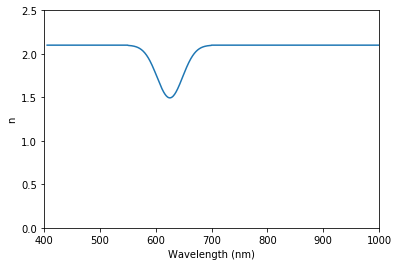

In [296]:
nz_hBN = -sig.gaussian(196, std=30)/1.65 + 2.1 
#nz_hBN_const = np.ones()
#nz_hBN = nz_hBN.append(10)
x1 = np.ones(187)*2.1 
x2 = np.ones(406)*2.1
nz_hBN_1 = np.concatenate((x1, nz_hBN), axis=0)
nz_hBN_2 = np.concatenate((nz_hBN_1, x2), axis=0)
fig1 = plt.figure(1)
ax1 = fig1.add_subplot(111)
ax1.plot(wavelength_store_bg[0],nz_hBN_2)

#plt.set_ylim(0, 2.1)
#sum_light_G = integrate.quad(lamda x: g_plot, 0, )
# print wavelength_store_bg
# np.where(wavelength_store_bg[0]==695.34115197)
data = np.zeros((789,4))
freq = (3e8)/(wavelength_store_bg[0]*1e-9)
data[:,0] = freq
data[:,1] = nz_hBN_2

ax1.set_ylim(0, 2.2)

np.savetxt("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Calculations/Generalized Mie NPoM/trilayer_uniaxial/misc/material/nhBN.txt", data, delimiter = "\t")
np.savetxt("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Calculations/Generalized Mie NPoM/trilayer/v0/misc/material/nhBN.txt", data, delimiter = "\t")

ax1.set_xlim(400, 1000)
ax1.set_ylim(0, 2.5)
ax1.set_xlabel("Wavelength (nm)")
ax1.set_ylabel("n")

fig1.savefig("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN/Calculation results/hBN_NL_refractive_index.png")




In [16]:
# Plot the average values of all spectra
colours_exp = cm.viridis(np.linspace(0,1,789))
colours_th = cm.hot(np.linspace(0,1,789))

In [29]:
energies

array([ 3.06313773,  3.05723032,  3.05134621,  3.04548526,  3.03964732,
        3.03383228,  3.02803998,  3.02227031,  3.01652312,  3.01079828,
        3.00509567,  2.99941516,  2.99375661,  2.9881199 ,  2.98250491,
        2.97691151,  2.97133957,  2.96578897,  2.9602596 ,  2.95475132,
        2.94926402,  2.94379758,  2.93835187,  2.93292679,  2.92752222,
        2.92213803,  2.91677412,  2.91143036,  2.90610666,  2.90080288,
        2.89551893,  2.89025469,  2.88501006,  2.87978491,  2.87457915,
        2.86939266,  2.86422534,  2.85907709,  2.85394779,  2.84883735,
        2.84374566,  2.83867261,  2.83361811,  2.82858206,  2.82356434,
        2.81856487,  2.81358354,  2.80862026,  2.80367492,  2.79874744,
        2.7938377 ,  2.78894563,  2.78407112,  2.77921407,  2.77437441,
        2.76955202,  2.76474682,  2.75995872,  2.75518763,  2.75043345,
        2.7456961 ,  2.74097549,  2.73627153,  2.73158413,  2.7269132 ,
        2.72225866,  2.71762042,  2.7129984 ,  2.70839251,  2.70

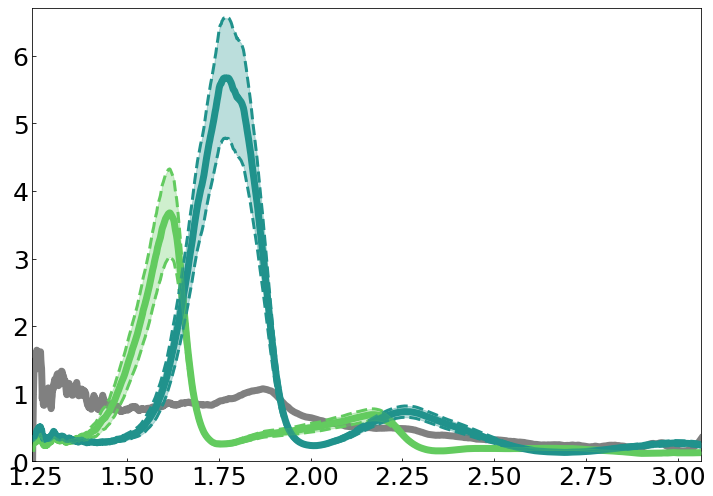

In [22]:
# Plot the average values of all spectra
colours_exp = cm.viridis(np.linspace(0,1,len(average_all_intensities_g)))
colours_th = cm.hot(np.linspace(0,1,len(average_all_intensities_g)))

#Plot green terrace DF from NPs
fig3=plt.figure(3, figsize = (10, 7))
ax7=fig3.add_subplot(111)
ax7.plot(energies, average_all_intensities_fano2*5*100, color = "grey", label = "DF Terrace 2 background x 5", linewidth = 7)

ax7.plot(energies, average_all_intensities_g*100, color = colours_exp[600], label = "DF Terrace 1 NPs", linewidth = 7)
ax7.plot(energies, av_stddev_g*100 + average_all_intensities_g*100, '--',color = colours_exp[600], label = "$\sigma$ DF Terrace 1",  linewidth = 3)
ax7.plot(energies, average_all_intensities_g*100 - av_stddev_g*100, '--' , color = colours_exp[600],  linewidth = 3)
ax7.fill_between(energies, average_all_intensities_g*100 - av_stddev_g*100,
                av_stddev_g*100 + average_all_intensities_g*100, color = colours_exp[600], 
                alpha = 0.3, zorder = 3)

#Plot orange terrace DF from NPs
ax7.plot(energies, average_all_intensities_o*100, color = colours_exp[400], label = "Terrace 2 NPs", linewidth = 7)
ax7.plot(energies, av_stddev_o*100 + average_all_intensities_o*100, '--', color = colours_exp[400], label = "$\sigma$ DF Terrace 2", linewidth = 3)
ax7.plot(energies, average_all_intensities_o*100 - av_stddev_o*100, '--', color = colours_exp[400],  linewidth = 3)
ax7.fill_between(energies, average_all_intensities_o*100 - av_stddev_o*100,
                av_stddev_o*100 + average_all_intensities_o*100, color = colours_exp[400], 
                alpha = 0.3, zorder = 3)

#Plot green terrace BF
#ax9 = ax7.twinx()
#line1, = ax9.plot(energies, average_all_intensities_bg*100,  color = colours[500], label = "BF Terrace 1", linewidth = 7)
#line1.set_dashes([1, 2, 3, 2])  # 2pt line, 2pt break, 10pt line, 2pt break


#Plot orange terrace BF
#line2, = ax9.plot(energies, average_all_intensities_bo*100, color = colours[400], label = "BF Terrace 2", linewidth = 7)
#line2.set_dashes([1, 2, 3, 2])  # 2pt line, 2pt break, 10pt line, 2pt break


#hBN_471nm_calc = np.genfromtxt("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN/Simulation results/Corr_471nm_hBN.txt", delimiter = "/n")



#Plot pink terrace BF
#ax9.plot(energies, average_all_intensities_bp, color = "pink", label = "Terrace 3 BF")


#ax7.legend(loc = "upper right", fontsize = 14)
ax7.tick_params(axis='x', labelsize=25, direction = 'in')
ax7.tick_params(axis='y', labelsize=25, direction = 'in')
#ax7.set_xlabel("Energy (eV)", fontsize = 40)
#ax7.set_ylabel("DF scattering (%)", fontsize = 40)

ax7.set_ylim(0,0.067*100)
ax7.set_xlim([min(energies), max(energies)])
#ax9.set_ylabel("Reflectivity vs Au (%)", fontsize = 40, rotation = -90, labelpad = 40)
#ax9.legend(loc = "upper left", fontsize = 14)
#ax9.set_ylim(30,147)
#ax9.tick_params(axis='y', labelsize=25, direction = 'in')

np.savetxt("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN publication/Fano_background.txt", average_all_intensities_fano2, delimiter = "\t")
np.savetxt("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN publication/Orange_terrace_DF.txt", average_all_intensities_o, delimiter = "\t")

np.savetxt("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN publication/Green_terrace_DF.txt", average_all_intensities_g, delimiter = "\t")
np.savetxt("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN publication/DF_energies.txt", energies, delimiter = "\t")


fig3.savefig('C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN publication/NP_BF_energyplot_w_bg_v2', bbox_inches='tight')

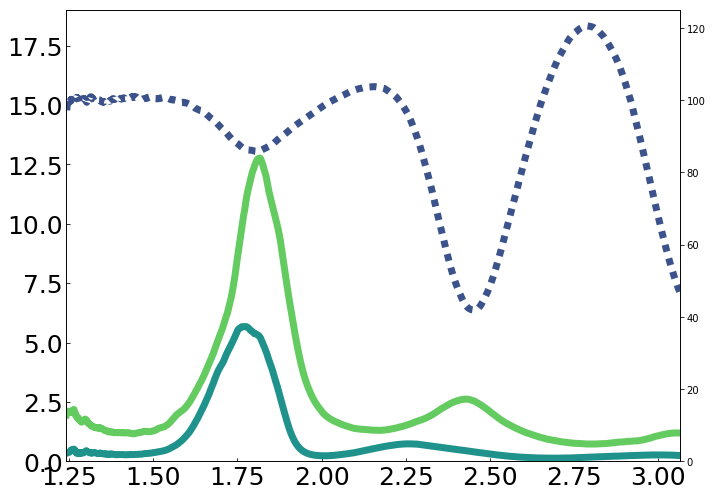

In [53]:
#Plot all offset spectra
# Plot the average values of all spectra
colours_exp = cm.viridis(np.linspace(0,1,len(average_all_intensities_g)))
colours_th = cm.hot(np.linspace(0,1,len(average_all_intensities_g)))

#Plot green terrace DF from NPs
fig=plt.figure(3, figsize = (10, 7))
ax=fig.add_subplot(111)
ax2 = ax.twinx()

ax.plot(energies, average_all_intensities_t2edge*100, color = colours_exp[600], label = "DF Terrace 1 NPs", linewidth = 7)
ax.plot(energies, av_stddev_t2edge*100 + average_all_intensities_t2edge*100, '--',color = colours_exp[600], label = "$\sigma$ DF Terrace 1",  linewidth = 3)
ax.plot(energies, average_all_intensities_t2edge*100 - av_stddev_t2edge*100, '--' , color = colours_exp[600],  linewidth = 3)
ax.fill_between(energies, average_all_intensities_t2edge*100 - av_stddev_t2edge*100,
                av_stddev_t2edge*100 + average_all_intensities_t2edge*100, color = colours_exp[600], 
                alpha = 0.3, zorder = 3)

#Plot orange terrace DF from NPs
ax.plot(energies, average_all_intensities_o*100, color = colours_exp[400], label = "Terrace 2 NPs", linewidth = 7)


#np.savetxt("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN publication/Experimental Terrace 2 BF.txt", average_all_intensities_bo, delimiter = "\n" )
average_all_intensities_bo = np.array(np.genfromtxt("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN publication/Experimental Terrace 2 BF.txt", delimiter = "/n"))


#Plot green terrace BF
#ax9 = ax7.twinx()
#line1, = ax9.plot(energies, average_all_intensities_bg*100,  color = colours[500], label = "BF Terrace 1", linewidth = 7)
#line1.set_dashes([1, 2, 3, 2])  # 2pt line, 2pt break, 10pt line, 2pt break


#Plot orange terrace BF
line2, = ax2.plot(energies, average_all_intensities_bo*100, color = colours_exp[200], label = "BF Terrace 2", linewidth = 7)
line2.set_dashes([1, 1, 1, 1])  # 2pt line, 2pt break, 10pt line, 2pt break


#hBN_471nm_calc = np.genfromtxt("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN/Simulation results/Corr_471nm_hBN.txt", delimiter = "/n")



#Plot pink terrace BF
#ax9.plot(energies, average_all_intensities_bp, color = "pink", label = "Terrace 3 BF")


#ax7.legend(loc = "upper right", fontsize = 14)
ax.tick_params(axis='x', labelsize=25, direction = 'in')
ax.tick_params(axis='y', labelsize=25, direction = 'in')
#ax7.set_xlabel("Energy (eV)", fontsize = 40)
#ax7.set_ylabel("DF scattering (%)", fontsize = 40)

ax.set_ylim(0,19)
ax.set_xlim([min(energies), max(energies)])
ax2.set_ylim(0, 125)

fig.savefig('C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN publication/T2 step vs NP and BF.png')



In [39]:
np.savetxt("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN/Fano_background.txt", average_all_intensities_fano2, delimiter = "\t")
np.savetxt("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN/Fano_wavelengths.txt", wavelength_store_fano2, delimiter = "\t")
np.savetxt("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN/Orange_terrace_DF.txt", average_all_intensities_o, delimiter = "\t")




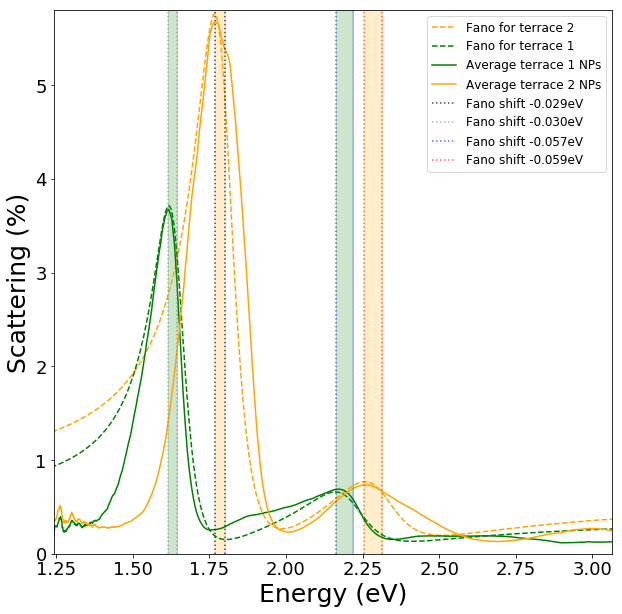

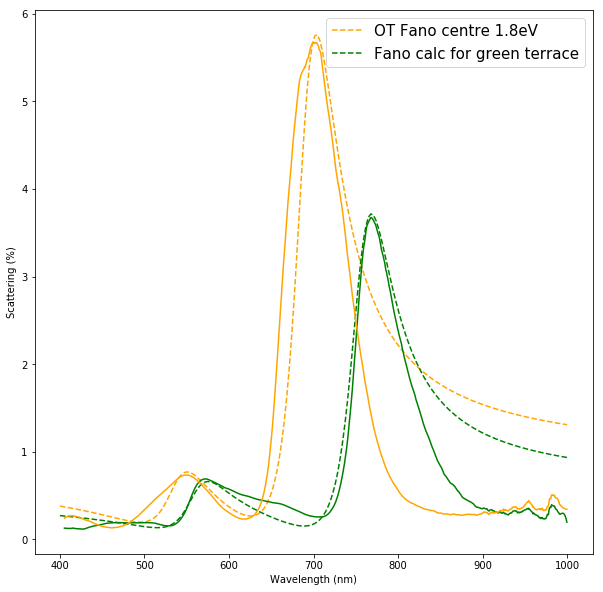

In [254]:
#Time to plot fano simulations 
Fano_green = np.genfromtxt("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN/Calculation results/Fano_resonance_green_terrace_Int.txt", delimiter = "/n")
Fano_orange = np.genfromtxt("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN/Calculation results/Fano_resonance_orange_terrace_Int.txt", delimiter = "/n")
Fano_wl = np.genfromtxt("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN/Calculation results/Fano_wl.txt", delimiter = "/n")
Fano_eng = np.genfromtxt("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN/Calculation results/Fano_eng.txt", delimiter = "/n")

fig6 = plt.figure(6, figsize = (10,10))
ax13 = fig6.add_subplot(111)
ax13.plot(Fano_eng, Fano_orange*0.85, color = "orange", linestyle = "--", label = "Fano for terrace 2")
ax13.plot(Fano_eng, Fano_green*0.55, color = "green", linestyle = "--", label = "Fano for terrace 1")
ax13.plot(energies, average_all_intensities_g*100, "g", label = "Average terrace 1 NPs")
ax13.plot(energies, average_all_intensities_o*100, "orange", label = "Average terrace 2 NPs")
ax13.set_ylabel("Scattering (%)", fontsize = 25)
ax13.set_xlabel("Energy (eV)", fontsize = 25)
ax13.tick_params(axis='x', labelsize=18)
ax13.tick_params(axis='y', labelsize=18)

ax13.axvline(x=1.8, color = "black", linestyle = ":", alpha = 0.7, label = "Fano shift -0.029eV")
ax13.axvline(x=1.77, color = "black", linestyle = ":", alpha = 0.7)
ax13.axvspan(1.77, 1.8, color = "orange", alpha = 0.2)
ax13.axvline(x=1.644, color = "grey", linestyle = ":", alpha = 0.6, label = "Fano shift -0.030eV")
ax13.axvline(x=1.614, color = "grey", linestyle = ":", alpha = 0.6)
ax13.axvspan(1.614, 1.644, color = "green", alpha = 0.2)
ax13.axvline(2.1624, color="blue", alpha = 0.6, linestyle = ":", label = "Fano shift -0.057eV")
ax13.axvline(2.2198, color="blue", alpha = 0.2)
ax13.axvspan(2.1624, 2.2198, color = "green", alpha = 0.2)
ax13.axvline(2.256, color="red", alpha = 0.6, linestyle = ":", label = "Fano shift -0.059eV")
ax13.axvline(2.315, color="red", alpha = 0.6, linestyle = ":")
ax13.axvspan(2.256, 2.315, color = "orange", alpha = 0.2)
ax13.set_ylim(0, 5.8)
ax13.set_xlim(min(energies), max(energies))
ax13.legend(fontsize = 12)


fig7 = plt.figure(7, figsize = (10,10))
ax14 = fig7.add_subplot(111)
ax14.plot(Fano_wl, Fano_orange*0.85, color = "orange", linestyle = "--", label = "OT Fano centre 1.8eV")
ax14.plot(Fano_wl, Fano_green*0.55, color = "green", linestyle = "--", label = "Fano calc for green terrace")
ax14.plot(wavelength_store_g[0], average_all_intensities_g*100, "g")
ax14.plot(wavelength_store_o[0], average_all_intensities_o*100, "orange")
ax14.legend(fontsize = 15)
ax14.set_ylabel("Scattering (%)")
ax14.set_xlabel("Wavelength (nm)")

fig6.savefig('C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN/Energy_fano_calcs.png')


In [27]:
hBN_470nm_calc = np.genfromtxt("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN/Calculation results/Corr_470nm_hBN.txt", delimiter = "/n")

fig4=plt.figure(4, figsize = (10, 10))
ax8=fig4.add_subplot(111)

max_anis = 2.25
min_anis = 1.75

#Plot green terrace BF
line1, = ax8.plot(energies, average_all_intensities_bg*100, color = "green", label = "BF Terrace 1")
line1.set_dashes([2, 2, 10, 2])  # 2pt line, 2pt break, 10pt line, 2pt break

np.savetxt("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN/Experimental Terrace 1 BF.txt", average_all_intensities_bg, delimiter = "\n" )
np.savetxt("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN/Experimental Terrace 2 BF.txt", average_all_intensities_bo, delimiter = "\n" )

#Plot orange terrace BF
line2, = ax8.plot(energies, average_all_intensities_bo*100, color = "orange", label = "BF Terrace 2")
line2.set_dashes([2, 2, 10, 2])  # 2pt line, 2pt break, 10pt line, 2pt break

hBN_400nm_calc = np.array(np.genfromtxt("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN/Calculation results/Corr_400nm_hBN.txt", delimiter = "/n"))
hBN_470nm_calc = np.array(np.genfromtxt("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN/Calculation results/Corr_470nm_hBN.txt", delimiter = "/n"))
eng_calc = np.array(np.genfromtxt("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN/Calculation results/Calc_energies.txt", delimiter = "/n"))
hBN_471nm_calc_15deg = np.array(np.genfromtxt("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN/Calculation results/Corr_471nm_hBN_15deg.txt", delimiter = "/n"))
hBN_400nm_calc_15deg =  np.array(np.genfromtxt("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN/Calculation results/Corr_400nm_hBN_15deg.txt", delimiter = "/n"))
hBN_492nm_calc =  np.array(np.genfromtxt("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN/Calculation results/Calc_492nmhBN_BF_R.txt", delimiter = "/n"))
energies_calc = np.array(np.genfromtxt("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN/Calculation results/Energies_calc_OOSpec.txt", delimiter = "/n"))
hBN_530nm_calc =  np.array(np.genfromtxt("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN/Calculation results/Calc_530nmhBN_BF_R_n1.9.txt", delimiter = "/n"))
hBN_449nm_calc =  np.array(np.genfromtxt("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN/Calculation results/Calc_449nmhBN_BF_R_n1.94.txt", delimiter = "/n"))



#ax7.plot(energies, hBN_470nm_red)
#ax8.plot(eng_calc, hBN_470nm_calc, color = "green", label = "470nm hBN Calculated BF")
#ax8.plot(eng_calc, hBN_400nm_calc*100, color = "orange", label = "400nm hBN Calculated BF")
#ax8.plot(eng_calc, hBN_471nm_calc_15deg*100, color = "green", label = "471nm hBN 15deg BF")
#ax8.plot(eng_calc, hBN_400nm_calc_15deg*100, color = "orange", label = "400nm hBN 15deg BF")
#ax8.plot(energies_calc, hBN_492nm_calc*100)
ax8.plot(energies_calc, hBN_530nm_calc*100, color = "green", label = "530nm n=1.94 BF_R Calc")
ax8.plot(energies_calc, hBN_449nm_calc*100, color = "orange", label = "449nm n=1.94 BF_R Calc")
ax8.legend(loc = "upper right", fontsize = 14)
ax8.tick_params(axis='x', labelsize=18, direction = 'in')
ax8.tick_params(axis='y', labelsize=18, direction = 'in')
ax8.set_xlabel("Energy (eV)", fontsize = 25)

ax8.set_xlim([min(energies), max(energies)])
ax8.set_ylabel("Reflectivity vs Au (%)", fontsize = 25, labelpad = 25)
ax8.legend(loc = "upper left", fontsize = 14)
ax8.set_ylim(0, 130)
ax8.tick_params(axis='y', labelsize=18)
ax8.text(1.5,20,'Omid loves you!')

fig4.savefig('C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN/Corrected_BF_comparison_194.png')

IOError: C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN/Calculation results/Corr_470nm_hBN.txt not found.

In [3]:
import matplotlib.cm as cm
colours = cm.viridis(np.linspace(0.25,0.75,5)) #the colour scheme goes from 0 to one but here I don’t want the extreme ends of the colourscale so I’ve divided into 5 colours from 0.25 to 0.75, you can obviously change any of those
#ax3.plot(x, y, color=colours[0]) #replace 0 with any other number in your range

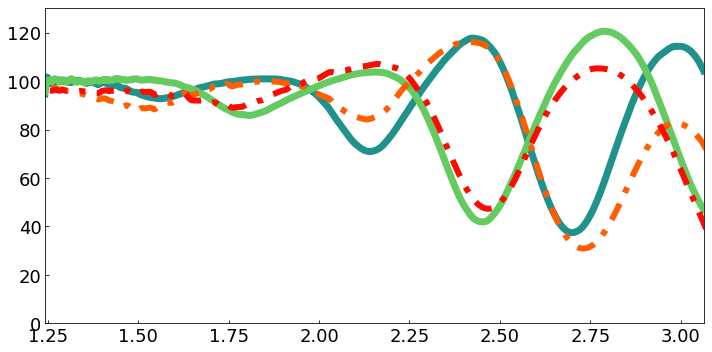

In [23]:


energiesJ = ((const.h * const.c)/(wavelength_store_bg[0]*(1e-9)))
    
energies = energiesJ/(1.6e-19)


#Second attempt at a fit with higher effective refractive index
fig4=plt.figure(4, figsize = (10, 5))
ax8=fig4.add_subplot(111)

#Plot green terrace BF
ax8.plot(energies, average_all_intensities_bg*100, color = colours_exp[400], label = "BF Terrace 1", linewidth = 7)

np.savetxt("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN publication/Experimental Terrace 1 BF.txt", average_all_intensities_bg, delimiter = "\n" )
np.savetxt("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN publication/Experimental Terrace 2 BF.txt", average_all_intensities_bo, delimiter = "\n" )

#Plot orange terrace BF
ax8.plot(energies, average_all_intensities_bo*100, color = colours_exp[600], label = "BF Terrace 2", linewidth = 7)

hBN_493nm_n207_calc = np.array(np.genfromtxt("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN publication/Calculation results/Calc_493nmhBN_BF_R_n2.07.txt", delimiter = "/n"))
hBN_419nm_n207_calc = np.array(np.genfromtxt("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN publication/Calculation results/Calc_419nmhBN_BF_R_n2.07.txt", delimiter = "/n"))
energies_calc = np.array(np.genfromtxt("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN publication/Calculation results/Energies_calc_OOSpec.txt", delimiter = "/n"))

line2, = ax8.plot(energies_calc, hBN_493nm_n207_calc*100,  color = colours_th[400], label = "493nm n=2.07 BF_R Calc", linewidth = 6)
line2.set_dashes([1, 2, 3, 2])  
line1, = ax8.plot(energies_calc, hBN_419nm_n207_calc*100,  color = colours_th[300], label = "419nm n=2.07 BF_R Calc", linewidth = 6)
line1.set_dashes([1, 2, 3, 2])
#ax8.legend(loc = "upper right", fontsize = 14)
ax8.tick_params(axis='x', labelsize=18, direction = 'in')
ax8.tick_params(axis='y', labelsize=18, direction = 'in')
#ax8.set_xlabel("Energy (eV)", fontsize = 25)

ax8.set_xlim([min(energies), max(energies)])
#ax8.set_ylabel("Reflectivity vs Au (%)", fontsize = 25, labelpad = 25)
#ax8.legend( fontsize = 14)
ax8.set_ylim(0, 130)
ax8.tick_params(axis='y', labelsize=18)

fig4.savefig('C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN publication/Corrected_BF_comparison_207.png')

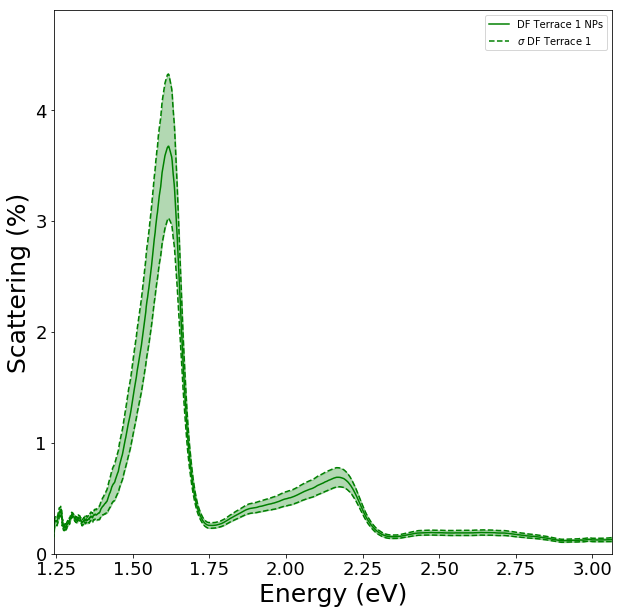

In [457]:
#Plotting data from GMM 
hBN470nm_GMM_av_P_0 = np.array(np.genfromtxt("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN/Calculation results/GMM 0deg av_P 470nm.txt", delimiter = "/n"))
hBN470nm_GMM_wl = np.array(np.genfromtxt("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN/Calculation results/GMM wl.txt", delimiter = "/n"))
hBN470nm_GMM_av_P_60 = np.array(np.genfromtxt("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN/Calculation results/GMM 60deg av_P 470nm.txt", delimiter = "/n"))
hBN470nm_GMM_EJ = ((const.h * const.c)/(hBN470nm_GMM_wl*(1e-9)))
hBN470nm_GMM_E = hBN470nm_GMM_EJ/(1.6e-19)
hBN470nm_GMM_PTE_60 = np.array(np.genfromtxt("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN/Calculation results/GMM 60deg PTE 470nm.txt", delimiter = "/n"))


#Plot green terrace DF from NPs
fig5=plt.figure(5, figsize = (10, 10))
ax10=fig5.add_subplot(111)
ax10.plot(energies, average_all_intensities_g*100, "green", label = "DF Terrace 1 NPs")
ax10.plot(energies, av_stddev_g*100 + average_all_intensities_g*100, '--', color = "green", label = "$\sigma$ DF Terrace 1")
ax10.plot(energies, average_all_intensities_g*100 - av_stddev_g*100, '--' , color = "green")
ax10.fill_between(energies, average_all_intensities_g*100 - av_stddev_g*100,
                av_stddev_g*100 + average_all_intensities_g*100, color = "green", 
                alpha = 0.3, zorder = 3)


#line1, = ax10.plot(hBN470nm_GMM_E, hBN470nm_GMM_PTE_60/1000, color = "red", label = "GMM PTE 470nm 60 degrees/1300")
#line1.set_dashes([2, 2, 10, 2])  # 2pt line, 2pt break, 10pt line, 2pt break


#line2, = ax10.plot(hBN470nm_GMM_E, hBN470nm_GMM_av_P_60/700, color = "black", label = "GMM av_P 470nm 60 degrees/700")
#line2.set_dashes([2, 2, 10, 2])  # 2pt line, 2pt break, 10pt line, 2pt break

#Plot green terrace BF
#ax11 = ax10.twinx()
#line1, = ax11.plot(energies, average_all_intensities_bg*100, color = "green", label = "BF Terrace 1")
#line1.set_dashes([2, 2, 10, 2])  # 2pt line, 2pt break, 10pt line, 2pt break

ax10.legend()
ax10.set_xlim(min(energies), max(energies))
ax10.set_xlabel("Energy (eV)", fontsize = 25)
ax10.set_ylabel("Scattering (%)", fontsize = 25)
ax10.set_ylim(0, 4.9)
ax10.tick_params(axis = "x", labelsize = 18)
ax10.tick_params(axis = "y", labelsize = 18)

fig5.savefig('C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN/GMM_0_60deg_470nmhBN_PTE')



In [470]:
print len(average_all_intensities_bo)

789


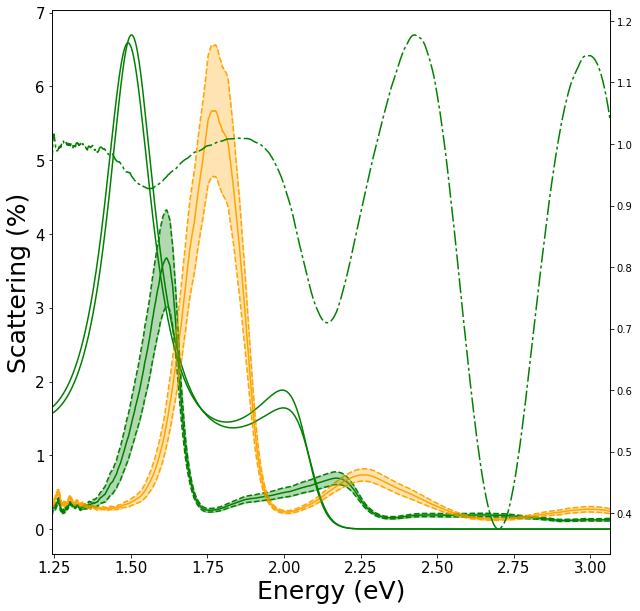

In [307]:
#Comparing experimental data to 1-calculated reflectance - including multiplication with multiple Au absorption

#Plot green terrace DF from NPs
fig6=plt.figure(6, figsize = (10, 10))
ax12=fig6.add_subplot(111)
ax12.plot(energies, average_all_intensities_g*100, "green", label = "DF Terrace 1 NPs")
ax12.plot(energies, av_stddev_g*100 + average_all_intensities_g*100, '--', color = "green", label = "$\sigma$ DF Terrace 1")
ax12.plot(energies, average_all_intensities_g*100 - av_stddev_g*100, '--' , color = "green")
ax12.fill_between(energies, average_all_intensities_g*100 - av_stddev_g*100,
                av_stddev_g*100 + average_all_intensities_g*100, color = "green", 
                alpha = 0.3, zorder = 3)


#Plot orange terrace DF from NPs
ax12.plot(energies, average_all_intensities_o*100, color = "orange", label = "Terrace 2 NPs")
ax12.plot(energies, av_stddev_o*100 + average_all_intensities_o*100, '--', color = "orange", label = "$\sigma$ DF Terrace 2")
ax12.plot(energies, average_all_intensities_o*100 - av_stddev_o*100, '--', color = "orange")
ax12.fill_between(energies, average_all_intensities_o*100 - av_stddev_o*100,
                av_stddev_o*100 + average_all_intensities_o*100, color = "orange", 
                alpha = 0.3, zorder = 3)

#Plot green terrace BF
ax13 = ax12.twinx()
line1, = ax13.plot(energies, average_all_intensities_bg, color = "green", label = "BF Terrace 1")
line1.set_dashes([2, 2, 10, 2])  # 2pt line, 2pt break, 10pt line, 2pt break


hBN_471nm_15deg_R_Au =  np.array(np.genfromtxt("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN/Calculation results/Corr_471nm_hBN_15deg_Tra_Au.txt", delimiter = "/n"))
hBN_471nm_15deg_T_Au = 1-hBN_471nm_15deg_R_Au 
hBN_471nm_0deg_R_Au =  np.array(np.genfromtxt("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN/Calculation results/Corr_471nm_hBN_0deg_Tra_Au.txt", delimiter = "/n"))
hBN_471nm_0deg_T_Au = 1-hBN_471nm_0deg_R_Au

Au_R =  np.array(np.genfromtxt("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN/Calculation results/Au Absorption.txt", delimiter = "/n"))
Au_abs = Au_R**18
ax12.plot(eng_calc, hBN_471nm_15deg_T_Au*Au_abs*100, color = "green", label = "471nm hBN 15deg BF")
ax12.plot(eng_calc, hBN_471nm_0deg_T_Au*Au_abs*100, color = "green", label = "471nm hBN 15deg BF")

ax12.set_xlim(min(energies), max(energies))

ax12.set_xlabel("Energy (eV)", fontsize = 25)
ax12.set_ylabel("Scattering (%)", fontsize = 25)
ax12.tick_params(axis = "x", labelsize = 15)
ax12.tick_params(axis = "y", labelsize = 15)

fig6.savefig('C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN/Enhanced_Au_absorption_calc')


In [104]:
#store all information in matrices for access later

all_info_wl = [name_store, wavelength_store, intensity_store, peak_wavelengths_store, 
               peak_intensities_store]
all_info_wl_norm = [name_store, wavelength_store, intensity_store_norm, peak_wavelengths_store, 
               peak_intensities_store]
all_info_indexed_norm = [name_store, wavelength_store, intensity_store_norm, peak_index_store, 
                    peak_intensities_store]

NameError: name 'name_store' is not defined

In [142]:
#need to ignore transverse mode for peak sorting, so sort by coupled modes instead

sorted_array_g = Alex_data.sort_coupled_modes(intensity_store_norm_g, 
                                            peak_wavelengths_store_g)
sorted_pk_intensities_g = Alex_data.sort_coupled_modes(peak_intensities_store_g, 
                                                     peak_wavelengths_store_g)

#ax1.scatter(peak_pos, y_value[peak_pos])
sorted_peak_wls_g = []
for i in range(0, len(sorted_array_g)):
    sorted_peak_wls_g.append(sorted_array_g[i][720:])
    
sorted_peak_wls_g = np.array(sorted_peak_wls_g)

while len(sorted_array[1]) > data_range_g:
    sorted_array_g = np.delete(sorted_array_g, [data_range], 1)
    
while len(sorted_pk_intensities[1]) > max_peaks:    
    sorted_pk_intensities_g = np.delete(sorted_pk_intensities_g, [max_peaks], 1) 

#Use function to add offset between each spectrum
sorted_array_offset_g = Alex_plot.offset_spectra(sorted_array)
sorted_pks_offset_g = Alex_plot.offset_spectra(sorted_pk_intensities)

NameError: name 'data_range_g' is not defined

In [26]:
#need to ignore transverse mode for peak sorting, so sort by coupled modes instead

sorted_array_o = Alex_data.sort_coupled_modes(intensity_store_norm_o, 
                                            peak_wavelengths_store_o)
sorted_pk_intensities_o = Alex_data.sort_coupled_modes(peak_intensities_store_o, 
                                                     peak_wavelengths_store_o)

#ax1.scatter(peak_pos, y_value[peak_pos])
sorted_peak_wls_g = []
for i in range(0, len(sorted_array)):
    sorted_peak_wls.append(sorted_array[i][720:])
    
sorted_peak_wls = np.array(sorted_peak_wls)

while len(sorted_array[1]) > data_range:
    sorted_array = np.delete(sorted_array, [data_range], 1)
    
while len(sorted_pk_intensities[1]) > max_peaks:    
    sorted_pk_intensities = np.delete(sorted_pk_intensities, [max_peaks], 1) 
    
#Use function to add offset between each spectrum
sorted_array_offset = Alex_plot.offset_spectra(sorted_array)
sorted_pks_offset = Alex_plot.offset_spectra(sorted_pk_intensities)

NameError: name 'sorted_array' is not defined

In [25]:
#Plot sorted and offset spectra with line thickness as a function of intensity
picno = 0
fig8 = plt.figure(picno+6, figsize = (10,0.2*len(sorted_array)))
ax8 = fig8.add_subplot(111)
ax10 = ax8.twiny()
ax10.set_xlim(ax6.get_xlim())
ax10.set_xticks(new_tick_locations)
ax10.set_xticklabels(Alex_plot.energy_ticks(new_tick_locations))
ax10.set_xlabel(r"Energy(eV)")


colours = parula_map(np.linspace(0,1,len(sorted_array_offset)))
for i in range(0, len(sorted_array_offset)):
    lwidths = (sorted_array_offset[i] - i)*2
    points = np.array([x_red, sorted_array_offset[i]]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis = 1)
    lc_2 = LineCollection(segments, linewidths = lwidths, color = colours[i])
    ax8.add_collection(lc_2)
    spec1 = np.array(sorted_array_offset[i], dtype = float)
    spec2 = np.array(len(sorted_array_offset[i])*[i], dtype = float)
    ax8.fill_between(x_red, spec1, spec2, color = "green", 
                alpha = 0.2, zorder = 3)
    #ax8.scatter(sorted_peak_wls[i], np.full((1,max_peaks), sorted_pks_offset[i]))


   
ax8.set_ylim(0, len(sorted_array_offset) + 2)
ax8.set_xlim(x_red[0], x_red[-1])
ax8.set_xlabel("Wavelength (nm)")
ax8.set_ylabel("Spectrum_no + Intensity (A.U)")

#plot map of sorted spectra

fig3=plt.figure(picno+4, figsize = (10, 15))
ax3=fig3.add_subplot(111)

all_sorted_array = np.array(sorted_array, dtype=float)

mapfig1 = ax3.imshow(all_sorted_array, 
                    extent=[wavelength_start, wavelength_end,
                    0, len(all_sorted_array)], aspect = 'auto', 
                            cmap = parula_map, vmin = min(average_all_intensities))
    
                        
fig3.colorbar(mapfig1)
ax3.tick_params(axis='x', labelsize=16)
ax3.tick_params(axis='y', labelsize=16)
ax3.set_xlabel("Wavelength(nm)", fontsize = 16)
ax3.set_ylabel("Spectrum number", fontsize = 16)
ax3.set_title(fname[slash_loc:-3] + "\nNormalised DF sorted by peak position", 
              fontsize = 18, y=1.2)
ax11 = ax3.twiny()
ax11.set_xlim(ax6.get_xlim())
ax11.set_xticks(new_tick_locations)
ax11.set_xticklabels(Alex_plot.energy_ticks(new_tick_locations))
ax11.set_xlabel(r"Energy(eV)")


print """Would you like to remove data above/below a max/min 
    peak value?"""
usr_input4 = raw_input(">> ")
if usr_input4 == 'y' or usr_input4 == 'Y':
    print "Remove data with initial peak wl (nm) below: "
    min_pk_wl = input(">> ")
    print "Remove data with initial peak wl (nm) above: "
    max_pk_wl = input(">> ")

    wavelength_store_cut = wavelength_store
    intensity_store_cut = intensity_store
    peak_wl_store_cut = peak_wavelengths_store

    del_no = 0
    while del_no < len(peak_wl_store_cut):
        if peak_wl_store_cut[del_no][0] < min_pk_wl or peak_wl_store_cut[del_no][0] > max_pk_wl:
            wavelength_store_cut = np.delete(wavelength_store_cut, del_no, 0)
            intensity_store_cut = np.delete(intensity_store_cut, del_no, 0)
            peak_wl_store_cut = np.delete(peak_wl_store_cut, del_no, 0)
        else:
            del_no = del_no + 1
        
    all_info_wl_cut = [wavelength_store_cut, intensity_store_cut, peak_wl_store_cut]

    sorting_array_2 = np.concatenate((intensity_store_cut, peak_wl_store_cut), axis = 1)
    sorted_array_2 = sorted(sorting_array_2, key=lambda x: x[data_range])
    
    while len(sorted_array_2[1]) > data_range:
        sorted_array_2 = np.delete(sorted_array_2, [data_end-data_start], 1)
    
    sorted_array_2 = np.delete(sorted_array_2, 0, 0)
    all_sorted_array_2 = np.array(sorted_array_2, dtype = float)
    
    fig5 = plt.figure(picno+5, figsize = (10,10))
    ax5 = fig5.add_subplot(111)

    mapfig2 = ax5.imshow(all_sorted_array_2, 
                         extent=[wavelength_start, wavelength_end,
                        0, len(all_sorted_array_2)], aspect = 'auto')
    fig5.colorbar(mapfig2)
    ax5.tick_params(axis='x', labelsize=10)
    ax5.tick_params(axis='y', labelsize=10)
    ax5.set_xlabel("Wavelength(nm)", fontsize = 15)
    ax5.set_ylabel("Spectrum number", fontsize = 15)
    ax5.set_title(fname[slash_loc:-3] + 
                 "\nReduced normalised DF sorted by peak position", 
                     fontsize = 18)
    fig5.savefig(fname[slash_loc:-3] + "_reduced map.png")
else:
    pass

data_f.flush()
data_f.close()

NameError: name 'sorted_array' is not defined

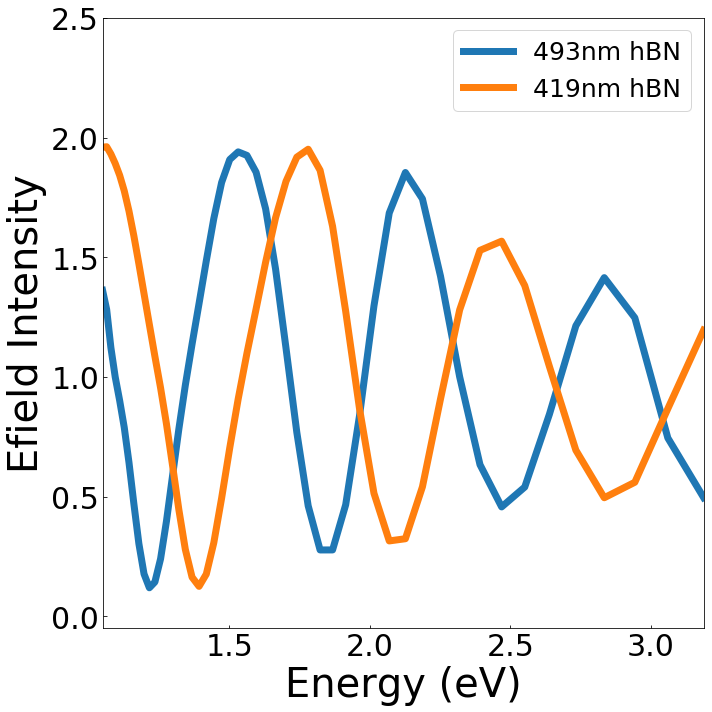

In [81]:
#Calculating the field at the interface using JJBs code 

hBN_493nm_hBN_air_field =  np.array(np.genfromtxt("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN publication/Calculation results/JJB_code_492nm_n207_EField_near_surface.txt"))
hBN_419nm_hBN_air_field =  np.array(np.genfromtxt("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN publication/Calculation results/JJB_code_419nm_n207_EField_near_surface.txt"))

wl_field = np.linspace(389.56633, 1182.9337, len(hBN_419nm_hBN_air_field))
en_field = 1241.52864/wl_field

hBN_493nm_hBN_air_field_f = sig.savgol_filter(hBN_493nm_hBN_air_field, 23, 9)
hBN_419nm_hBN_air_field_f = sig.savgol_filter(hBN_419nm_hBN_air_field, 23, 9)

fig1=plt.figure(1, figsize = (10, 10))
ax1 = fig1.add_subplot(111)
ax1.plot(en_field, hBN_493nm_hBN_air_field_f, label = '493nm hBN', linewidth = 7)
ax1.set_ylabel('Efield Intensity', fontsize = 40 )
ax1.set_xlabel('Energy (eV)', fontsize = 40)
ax1.set_xlim(min(en_field), max(en_field))
ax1.set_ylim(-0.05, 2.5)
ax1.plot(en_field, hBN_419nm_hBN_air_field_f, label = '419nm hBN',linewidth = 7)
ax1.legend(fontsize = 25)
ax1.tick_params(axis='x', labelsize=30, direction = 'in')
ax1.tick_params(axis='y', labelsize=30, direction = 'in')

fig1.savefig('C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN publication/Calculation results/Field just above hBN 419-494nm.png')


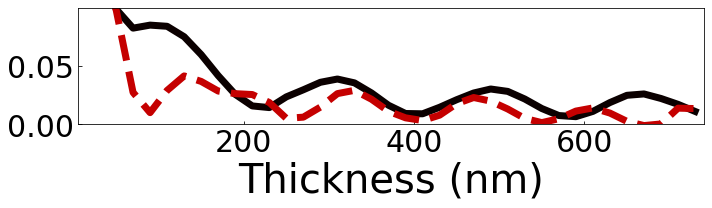

In [97]:
QvstfactorAuNP =  np.array(np.genfromtxt("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN publication/Calculation results/Qvst_60nmAuNP_vs_t.txt"))
Thicknesses =  np.array(np.genfromtxt("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN publication/Calculation results/Thicknesses_730nm.txt"))
QvstfactorSiNP =  np.array(np.genfromtxt("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN publication/Calculation results/Qvst_60nmSiNP_vs_t.txt"))
#QfactorAuNP = 
QvstfactorAuNP_f = sig.savgol_filter(QvstfactorAuNP, 23, 10)
QvstfactorSiNP_f = sig.savgol_filter(QvstfactorSiNP, 23, 14)

fig1=plt.figure(0, figsize = (10, 3))
ax1 = fig1.add_subplot(111)
ax1.plot(Thicknesses, QvstfactorAuNP_f, linewidth = 7, color = colours_th[0])
ax1.plot(Thicknesses, QvstfactorSiNP_f, linewidth = 7, color = colours_th[220], linestyle = "--")
#ax1.set_ylabel('QFactor/t (nm $^-1$)', fontsize = 40 )
ax1.set_xlabel('Thickness (nm)', fontsize = 40)
ax1.set_xlim(5, 740)
ax1.set_ylim(0, 0.099)
#ax1.plot(en_field, hBN_419nm_hBN_air_field, label = '419nm hBN',linewidth = 7)
#ax1.legend(fontsize = 25)
ax1.tick_params(axis='x', labelsize=30, direction = 'in')
ax1.tick_params(axis='y', labelsize=30, direction = 'in')

fig1.savefig('C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN publication/Calculation results/Qvst_vst Au compared to Si.png')


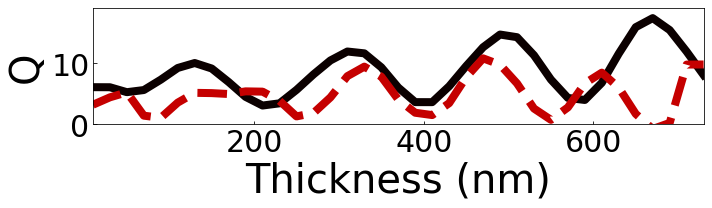

In [95]:
QfactorAuNP =  np.array(np.genfromtxt("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN publication/Calculation results/Q_60nmAuNP_vs_t.txt"))
Thicknesses =  np.array(np.genfromtxt("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN publication/Calculation results/Thicknesses_730nm.txt"))
QfactorSiNP =  np.array(np.genfromtxt("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN publication/Calculation results/Q_60nmSiNP_vs_t.txt"))

QfactorAuNP_f = sig.savgol_filter(QfactorAuNP,23,10)
QfactorSiNP_f = sig.savgol_filter(QfactorSiNP, 23,14)


fig1=plt.figure(0, figsize = (10, 3))
ax1 = fig1.add_subplot(111)
ax1.plot(Thicknesses, QfactorAuNP_f, linewidth = 8, color = colours_th[0], linestyle = "-")
ax1.plot(Thicknesses, QfactorSiNP_f, linewidth = 8, color = colours_th[220], linestyle = "--")
#ax2.plot(Thicknesses, QfactorSiNP, linewidth = 5, color = colours_th[220], linestyle = "--")

#spec1 = np.array(QfactorSiNP_f, dtype = float)
#spec2 = np.zeros(len(Thicknesses))
#ax2.fill_between(Thicknesses, spec1, spec2, color = colours_th[220], alpha = 0.5, zorder = 3)

#spec1 = np.array(QfactorAuNP_f, dtype = float)
#spec2 = np.zeros(len(Thicknesses))
#ax1.fill_between(Thicknesses, spec1, spec2, color = colours_th[0], alpha = 0.15, zorder = 3)


ax1.set_ylabel('Q', fontsize = 40)
ax1.set_xlabel('Thickness (nm)', fontsize = 40)
ax1.set_xlim(10, 730)
ax1.set_ylim(0, 19)

#ax1.plot(en_field, hBN_419nm_hBN_air_field, label = '419nm hBN',linewidth = 7)
#ax1.legend(fontsize = 25)
ax1.tick_params(axis='x', labelsize=30, direction = 'in')
ax1.tick_params(axis='y', labelsize=30, direction = 'in')
ax2.tick_params(axis= 'y', labelsize = 30, direction = 'in')

fig1.savefig('C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Fabry-Perot hBN publication/Calculation results/Qfactor Au vs Si.png')
